### Imports

In [235]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Directorio de imágenes

In [236]:
base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

### Escalamiento y Preprocesado

In [249]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Función para ajustar contraste
def adjust_contrast(image):
    contrast_factor = np.random.uniform(0.8, 1.2)
    mean = np.mean(image)
    image = (image - mean) * contrast_factor + mean
    return np.clip(image, 0, 1)

# Función combinada para ruido y contraste
def custom_preprocess(image):
    image = image / 255.0    # Normaliza a [0, 1]
    noisy_image = image + np.random.normal(0, 0.01, image.shape) # Añadir ruido gaussiano
    noisy_image = np.clip(noisy_image, 0, 1)
    return adjust_contrast(noisy_image)  # Ajustar contraste


train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=10.0,
    preprocessing_function=custom_preprocess,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

In [250]:
# Generators
# Cargar imágenes de las carpetas y redimencionarlas

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size = (150, 150),
	batch_size = 10,  
	class_mode ='categorical', # 'categorical' para más de 2 clases a clasificar
	shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4889 images belonging to 7 classes.
Found 487 images belonging to 7 classes.
Found 486 images belonging to 7 classes.


<Figure size 640x480 with 0 Axes>

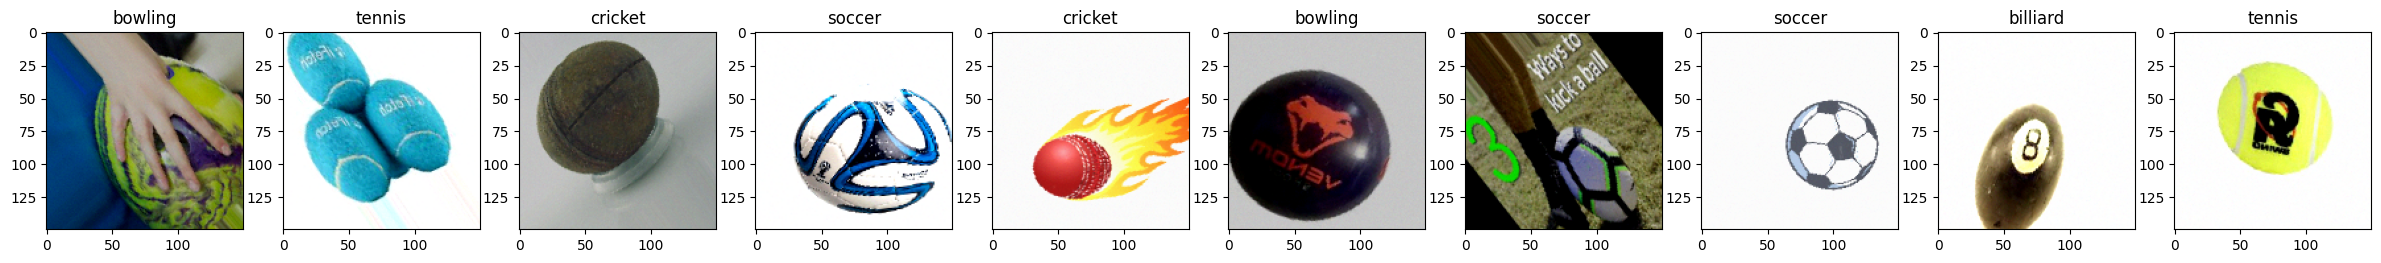

In [251]:
# Visualizar imágenes despúes de escalamiento y preprocesado
images, labels = train_generator[0]

class_names = list(train_generator.class_indices.keys()) # Obtener nombres de clases
label_indices = labels.argmax(axis=1)  # Convierte etiquetas a índices

plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]):
    axarr[i].imshow(images[i].squeeze()) 
    axarr[i].set_title(class_names[label_indices[i]], fontsize=12)

### Implementación del Modelo: Inspirado en la arquitectura ICNN-BNDOA

In [253]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras import optimizers


def get_model_deep(input_shape, num_classes=7):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dropout(0.1),
        
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

    return model

In [255]:
num_classes = train_generator.num_classes

model = get_model_deep((150, 150, 3), num_classes=num_classes)
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 37, 37, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_70 (Dropout)        (None, 37, 37, 32)        0         
                                                                 
 conv2d_73 (Conv2D)          (None, 37, 37, 64)      

In [256]:
def train_model_deep(model, train_generator, validation_generator):
    history = model.fit(train_generator, epochs=100, validation_data=validation_generator)
    return history
    
history = train_model_deep(model, train_generator, validation_generator)

Epoch 1/100
489/489 [==============================] - 40s 82ms/step - loss: 1.8735 - accuracy: 0.2227 - val_loss: 1.6516 - val_accuracy: 0.3634
Epoch 2/100
489/489 [==============================] - 37s 77ms/step - loss: 1.6290 - accuracy: 0.3723 - val_loss: 1.5868 - val_accuracy: 0.4045
Epoch 3/100
489/489 [==============================] - 37s 76ms/step - loss: 1.5688 - accuracy: 0.4121 - val_loss: 1.4637 - val_accuracy: 0.4682
Epoch 4/100
489/489 [==============================] - 37s 76ms/step - loss: 1.5110 - accuracy: 0.4375 - val_loss: 1.3923 - val_accuracy: 0.5133
Epoch 5/100
489/489 [==============================] - 37s 76ms/step - loss: 1.4614 - accuracy: 0.4749 - val_loss: 1.3343 - val_accuracy: 0.5359
Epoch 6/100
489/489 [==============================] - 38s 78ms/step - loss: 1.4099 - accuracy: 0.4999 - val_loss: 1.2803 - val_accuracy: 0.5647
Epoch 7/100
489/489 [==============================] - 38s 78ms/step - loss: 1.3467 - accuracy: 0.5171 - val_loss: 1.2217 - val_ac

In [263]:
# Guardar modelo
model.save('modelo_bien.h5')

# Guardar history
import pickle
with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [218]:
# Cargar modelo guardado
from tensorflow.keras.models import load_model
import pickle

model = load_model("modelo_bien.h5")

with open("history.pkl", "rb") as f:
    history_dict = pickle.load(f)

### Evaluación del Modelo

In [257]:
from sklearn.metrics import classification_report

# Obtener predicciones
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Etiquetas verdaderas
y_true = test_generator.classes

# Nombres de clases
class_labels = list(test_generator.class_indices.keys())

# Reporte de métricas
print("Reporte:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))



16/16 [==============================] - 2s 102ms/step
Reporte:

              precision    recall  f1-score   support

    billiard       0.92      0.86      0.89        66
     bowling       0.75      0.59      0.66        70
     cricket       0.77      0.79      0.78        70
    football       0.88      0.94      0.91        70
        golf       0.57      0.61      0.59        70
      soccer       0.71      0.73      0.72        70
      tennis       0.80      0.87      0.84        70

    accuracy                           0.77       486
   macro avg       0.77      0.77      0.77       486
weighted avg       0.77      0.77      0.77       486



#### Gráfica Val vs. Tran

In [258]:
results = model.evaluate(test_generator)

print('\nTest loss:', results[0])
print('Test accuracy:', results[1])

16/16 [==============================] - 2s 98ms/step - loss: 0.7724 - accuracy: 0.7695

Test loss: 0.7723658084869385
Test accuracy: 0.7695473432540894


16/16 [==============================] - 2s 101ms/step - loss: 0.7724 - accuracy: 0.7695


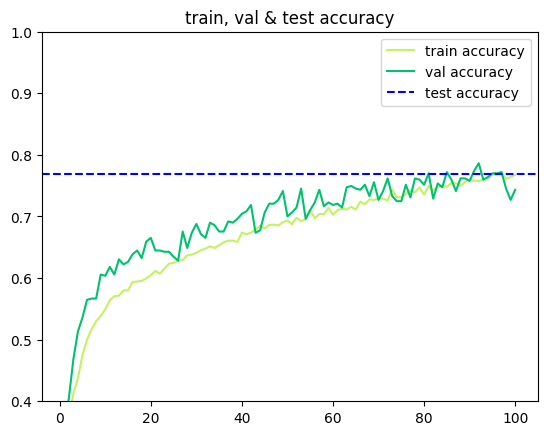

16/16 [==============================] - 2s 102ms/step - loss: 0.7724 - accuracy: 0.7695


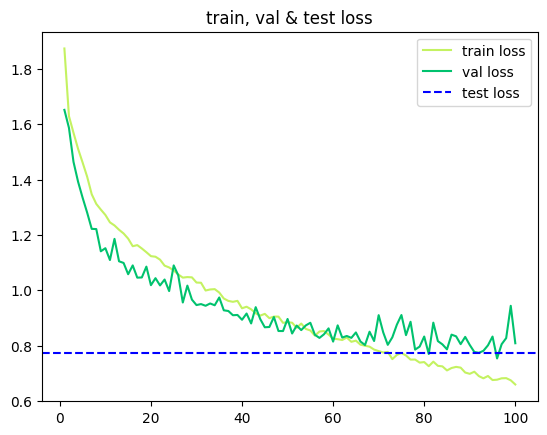

In [259]:
# Accuracy
test_loss, test_acc = model.evaluate(test_generator)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, color='#C4F261', label='train accuracy')
plt.plot(epochs, val_accuracy, color='#00C26E', label='val accuracy')
plt.axhline(y=test_acc, color='blue', linestyle='--', label='test accuracy')
plt.title('train, val & test accuracy')
plt.ylim(0.4, 1)
plt.legend()
plt.show()

# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

results = model.evaluate(test_generator)
test_loss = results[0]  

plt.figure()
plt.plot(epochs, train_loss, color='#C4F261', label='train loss')  
plt.plot(epochs, val_loss, color='#00C26E', label='val loss')     
plt.axhline(y=test_loss, color='blue', linestyle='--', label='test loss')

plt.title('train, val & test loss')
plt.legend()
plt.show()

16/16 [==============================] - 2s 94ms/step


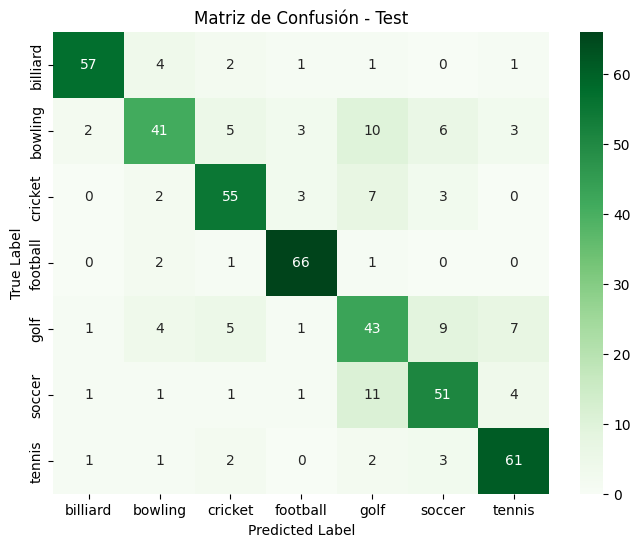

In [260]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Obtener predicciones del modelo
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas verdaderas del generador
y_true = test_generator.classes

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [264]:
print(train_generator.class_indices)


{'billiard': 0, 'bowling': 1, 'cricket': 2, 'football': 3, 'golf': 4, 'soccer': 5, 'tennis': 6}
